# LFD Homework 7

Seventh week homework for the "Learning from Data" course offerd by [Caltech on edX](https://courses.edx.org/courses/course-v1:CaltechX+CS1156x+3T2017). Note that this notebook does not contain *all* solutions; it showcases solutions to those problems that require programming / simulation (and omits pen and paper problems).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import requests
import scipy.optimize as opt
from sklearn import svm

%matplotlib notebook

## Validation (P1 - P5)

This group of problems re-uses the data and non-linear transforms employed as part of HW6. The data sets used in these problems can be found at

 * http://work.caltech.edu/data/in.dta
 * http://work.caltech.edu/data/out.dta

where `in.dta` corresponds to the training set and `out.dta` to the test set. In these files, each line contains a training example $(x_1, x_2, y)$ so that $\mathcal{X} = \mathbb{R}^2$ and $\mathcal{Y} = \{-1, 1\}$. 

The non-linear transformation applied before classification through linear regression (without regularization) is $\Phi: \mathcal{X} \mapsto \mathcal{Z}$ where each input is mapped to

$$
\Phi(x_1, x_2) = (1, x_1, x_2, x_1^2, x_2^2, x_1x_2, |x_1 - x_2|, |x_1 + x_2|)
$$

The re-used implementations from HW6 are:

In [2]:
def load_data():
    '''Loads the data directly from the caltech website.'''
    
    r = requests.get('http://work.caltech.edu/data/in.dta'); r.raise_for_status()
    data = np.loadtxt(r.content.splitlines())
    X, Y = np.split(data,[2], axis=-1)
    
    r = requests.get('http://work.caltech.edu/data/out.dta'); r.raise_for_status()
    data = np.loadtxt(r.content.splitlines())
    X_t, Y_t = np.split(data,[2], axis=-1)
    
    return X, Y, X_t, Y_t


def Phi(X):
    '''Non-linear transformation applied before linear regression.'''
    x1, x2 = np.hsplit(X, 2)
    Z = np.concatenate((X, x1**2, x2**2, x1 * x2, np.abs(x1 - x2), np.abs(x1 + x2)), axis=1)
    return Z


class LRBClassifier:
    ''' Simple linear regression based binary classifier.'''
    
    def __init__(self, X, Y, lambd=0, add_intercept=True):       
        N, d = X.shape
        if add_intercept:
            X = np.concatenate((np.ones((N, 1)), X), axis=1)
            I = np.eye(d+1)
        else:
            I = np.eye(d)

        self.w = np.linalg.pinv(X.T @ X + lambd * I) @ (X.T) @ Y
        self.E_in = np.sum(self(X, add_intercept=False) != Y)/N
    
    def __call__(self, X, add_intercept=True):
        N, d = X.shape
        if add_intercept:
            X = np.concatenate((np.ones((N, 1)), X), axis=1)
        
        return np.sign(X @ self.w).reshape(-1,1)

    def E(self, X, Y, add_intercept=True):
        N, d = X.shape
        if add_intercept:
            X = np.concatenate((np.ones((N, 1)), X), axis=1)
            
        E = np.sum(Y != self(X, add_intercept=False)) / float(N)
        return E

To illustrate how taking out points for validation affects the performance, we will consider the hypotheses trained on $\mathcal{D}_{\mathrm{train}}$ only (without restoring the full $\mathcal{D}$ for training after validation is done).

First, we load the data sets:

In [3]:
X, Y, X_t, Y_t = load_data()

### P1

Split the training data into training (first 25) and validation (last 10) sets. Train on the 25 examples only, using the validation set of 10 examples to select between five models that apply linear regression to $(\phi_0, \ldots, \phi_k)$ with $k \in \{3, 4, 5, 6, 7\}$. For which model is the classification error on the validation set smallest? 

In [4]:
# apply Phi, split data
Z, Z_t = Phi(X), Phi(X_t)
Z_train, Z_val = Z[:-10], Z[-10:]
Y_train, Y_val = Y[:-10], Y[-10:]

# train models and retrieve validation Error
K = np.arange(3,8, dtype=int)
models = [LRBClassifier(Z_train[:,:k], Y_train) for k in K]
E_val = np.array([g.E(Z_val[:,:i+3], Y_val) for i,g in enumerate(models)])

# select and report model with minimal validation error
idx = np.argmin(E_val)
print('Minimal Error (Validation)\n'+ '-'*26 +'\n[{}] k = {}'.format('abcde'[idx], int(idx) + 3))

Minimal Error (Validation)
--------------------------
[d] k = 6


### P2

Evaluate the out-of-sample classification error using the test data on the 5 models to see how well the validation set predicted the best of the 5 models. For which model ist out-of-sample classification error smallest?

In [5]:
E_out = np.array([g.E(Z_t[:,:i+3], Y_t) for i,g in enumerate(models)])

# select and report model with minimal out of sample error
idx = np.argmin(E_out)
print('Minimal Error (Out)\n'+ '-'*19 +'\n[{}] k = {}'.format('abcde'[idx], int(idx) + 3))

Minimal Error (Out)
-------------------
[e] k = 7


### P3

Reverse the role of training and validation sets; now training with the last 10 examples and validating with the first 25 examples. For which model is the classification error on the validation set smallest?

In [6]:
# train models and retrieve validation Error
models_rev = [LRBClassifier(Z_val[:,:k], Y_val) for k in K]
E_val_rev = np.array([g.E(Z_train[:,:i+3], Y_train) for i,g in enumerate(models)])

# select and report model with minimal validation error
idx = np.argmin(E_val_rev)
print('Minimal Error (Validation)\n'+ '-'*26 +'\n[{}] k = {}'.format('abcde'[idx], int(idx) + 3))

Minimal Error (Validation)
--------------------------
[d] k = 6


### P4

Once again, evaluate the out-of-sample classification error using the test data on the 5 models to see how well the validation set predicted the best of the 5 models. For which model is the out-of-sample classification error smallest?

In [7]:
E_out_rev = np.array([g.E(Z_t[:,:i+3], Y_t) for i,g in enumerate(models_rev)])

# select and report model with minimal out of sample error
idx = np.argmin(E_out_rev)
print('Minimal Error (Out)\n'+ '-'*19 +'\n[{}] k = {}'.format('abcde'[idx], int(idx) + 3))

Minimal Error (Out)
-------------------
[d] k = 6


To develop a feeling for how these two partitioning schemes compare over the different models, take a look at these plots:

<IPython.core.display.Javascript object>


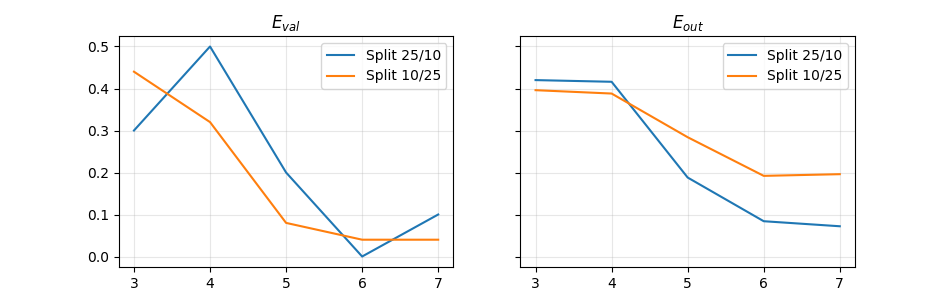

In [8]:
fig, (ax1, ax2) = plt.subplots(1,2, sharex=True, sharey=True, figsize=(9.5,3))

l1 = ax1.plot(K, E_val, label='Split 25/10')
l2 = ax1.plot(K, E_val_rev, label='Split 10/25')
ax1.set_title('$E_{val}$'); ax1.grid(alpha=.3); ax1.legend();

ax2.plot(K, E_out, label='Split 25/10')
ax2.plot(K, E_out_rev, label='Split 10/25')
ax2.set_title('$E_{out}$'); ax2.grid(alpha=.3); ax2.legend();

### P5

What values are closest in Euclidean distance to the out-of-sample classification error obtained for the model chosen in problems 1 and 3 respectively?

In [9]:
def choose_closest(choices, point, print_result=True):
    '''Choose the closest point to a given point (euclidean distance).'''
    
    distances = np.sqrt(np.sum((choices - point)**2, axis=0))
    idx = np.argmin(distances)
 
    if print_result:
        print(('Closest choice\n'+'-'*14+'\n[{}] (' + ('{:.3f}, '*point.shape[0])[:-2] + ')')
              .format('abcde'[idx], *choices[:, idx]))
        
    return choices[:, idx]


choose_closest(
    np.array([
        [0., .1, .1, .2, .2],
        [.1, .2, .3, .2, .3]
    ]),
    np.array([[E_out.min()], [E_out_rev.min()]])
);

Closest choice
--------------
[b] (0.100, 0.200)


## Validation Bias (P6)

Let $e_1$ and $e_2$ be independent random variables, distributed uniformly over the interval $[0, 1]$. Let $e = \min(e_1, e_2)$. Then the expected values of $e_1, e_2, e$ are closest to which of the given choices?

### P6

While the analytic soltion (aka integral juggling) is more easily done on paper, the result of $\mathbb{E}[e_1] = \frac{1}{2}, \mathbb{E}[e_2] = \frac{1}{2}$ and $\mathbb{E}[e] = \frac{1}{3}$ can also be estimated (checked) by simulation:

In [10]:
e = np.random.rand(int(1e5), 2)
e = np.concatenate((e, e.min(axis=1, keepdims=True)), axis=1)
E_e = e.mean(axis=0).reshape(-1,1)

choose_closest(
    np.array([
        [.5, .5, .5, .5, .5],
        [.5, .5, .5, .5, .5],
        [0., .1, .25, .4, .5]
    ]),
    E_e
);

Closest choice
--------------
[d] (0.500, 0.500, 0.400)


## PLA vs SVM

In theses problems, we compare PLA with SVM with hard margin on linearly separable data sets. The test data is identically to the data used in the previous assignments with $\mathcal{X} = [-1, 1] \times [-1, 1]$ and $d = 2$. Therefore, we can re-use the data generation and PLA implementation from past assignments:

In [11]:
def generate_data(N = 10, f=None):
    ''' Generates linear target function f and labeled, linearly separable test data generated by f.'''
    
    if f is None:
        # choose two random points p1, p2 and compute a vector p orthogonal to their difference
        p1, p2 = (np.random.rand(2,2) - 0.5) * 2.
        p = np.array([1, -(p2 - p1)[0]/(p2 - p1)[1]])
        p /= np.linalg.norm(p)
    
        f = lambda x: np.sign((x - p1) @ p).reshape(-1,1)
        f.db = lambda x: (p2[1] - p1[1])/(p2[0] - p1[0]) * (x - p1[0]) + p1[1]
    
    # generate uniformely distributed data points and apply classifier to label them
    X = (np.random.rand(N, 2) - 0.5) * 2
    Y = f(X)
    
    return X,Y,f


def plot_data(X, Y, db = None):
    ''' Plots two dimensional, linearly separable data from the interval [-1, 1] and the optional decision boundary db.'''
    
    plt.figure()
    
    pos_examples = X[(Y == 1).reshape(-1)]
    neg_examples = X[(Y == -1).reshape(-1)]
    neu_examples = X[(Y == 0).reshape(-1)]
    
    # plot the three groups of examples
    plt.scatter(pos_examples[:,0], pos_examples[:,1], color='steelblue', marker='+')
    plt.scatter(neg_examples[:,0], neg_examples[:,1], color='red', marker='o')
    plt.scatter(neu_examples[:,0], neu_examples[:,1], color='black', marker='o')
    
    # plot the decision boundary if provided
    if db is not None:
        x = np.arange(-1., 1., 0.01)
        plt.plot(x, db(x), c='red', ls='dashed', lw=1.)
    
    plt.grid(alpha=.3)
    plt.gca().set_xlim(-1, 1)
    plt.gca().set_ylim(-1, 1)

So for $N = 100$ data points, the generated data looks like:

<IPython.core.display.Javascript object>


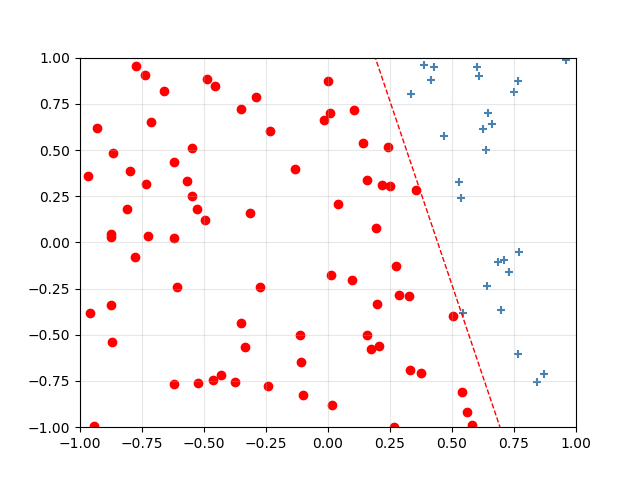

In [12]:
X, Y, f = generate_data(100)
plot_data(X, Y, f.db)

### PLA

The problems contrast PLA with SVM. Therefore, we can also re-use the PLA implementation from HW1 and HW2:

In [13]:
class PerceptronClassifier:
    '''Perceptron binary classifier.'''
    
    def __init__(self, X, Y, add_intercept=True, init_w=None, max_iter=10e5):       
        N, d = X.shape
        if add_intercept:
            X = np.concatenate((np.ones((N, 1)), X), axis=1)
        
        self.w = np.zeros((d+1, 1)) if init_w is None else init_w

        # perceptron learning algorithm
        X_prime, Y_prime = X.copy(), Y.copy()
        self.iterations = 0
    
        while X_prime.shape[0] > 0:
            # randomly select misclassified point
            i = np.random.randint(X_prime.shape[0])
            x_i, y_i = X_prime[i], Y_prime[i]
            
            # update hypothesis
            self.w += y_i * x_i.reshape(-1,1)
        
            # identify misclassified points
            idx = (self(X, add_intercept=False) != Y).reshape(-1)
            X_prime, Y_prime = X[idx], Y[idx]
            self.iterations += 1
        
            # divergence circuit breaker
            if self.iterations >= max_iter:
                raise StopIteration('maximum of {} iterations reached'.format(max_iter))
    
    def __call__(self, X, add_intercept=True):
        N = X.shape[0]
        if add_intercept:
            X = np.concatenate((np.ones((N, 1)), X), axis=1)
        
        return np.sign(X @ self.w).reshape(-1,1)
    
    def E(self, X, Y, add_intercept=True):
        N, d = X.shape
        if add_intercept:
            X = np.concatenate((np.ones((N, 1)), X), axis=1)
            
        E = np.sum(Y != self(X, add_intercept=False)) / float(N)
        return E

### SVM

Now the SVM implementation bases on the same structure, but has a little bit more involved learning algorithm. Here we will base learning on the dual formulation of the Lagrangian. Thereby, the dual formulation of the Lagrangian $\mathcal{L}(\alpha)$ from slides 14 and 15 can be expressed using matrix multiplication and  $\odot$ as

$$
\mathcal{L}(\alpha) = \frac{1}{2} \alpha^\intercal \left(\mathbf{Y}\mathbf{Y}^\intercal \odot \mathbf{X}\mathbf{X}^\intercal\right) \alpha + \left(-\mathbf{1}^\intercal\right) \alpha
$$

Let $\mathbf{Q} = \left(\mathbf{Y}\mathbf{Y}^\intercal \odot \mathbf{X}\mathbf{X}^\intercal\right)$, then we can use quadratic programming to solve the minimization problem

$$
\begin{array}{rl}
\min_{\alpha} & \mathcal{L}(\alpha) = \frac{1}{2} \alpha^\intercal \mathbf{Q} \alpha + \left(-\mathbf{1}^\intercal\right) \alpha \\
\mathrm{s.t.} & \mathbf{Y}^\intercal\alpha = \mathbf{0} \\
& \mathbf{0} \leq \alpha \leq \infty
\end{array}
$$


#### Solving the Minimization Problem

In order to solve such problems efficiently, we either need to implement quadratic programming with inequality constraints ourselves (which is beyond the scope of this homework), or we have to rely on external libraries such as [`covxopt`](http://cvxopt.org/). The latter choice comes at the cost of non-trivial installation and potential mismatched dependencies. In  my case, there are no binaries available for my combination of operating system / Python version. Building from scratch runs into problems with other pre-built libraries etc. 

A simple solution to this dilemma, is to forfeit potential performance gains from quadratic programming and use one of the generic solvers packaged with `scipy`, e.g., the constraint optimization solver employing [sequential least squares programming (SLSQP)](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-slsqp.html#optimize-minimize-slsqp). For details on how to use these, see `scipy`'s [optimization tutorial](https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html).

This approach will be slower and a bit less precise, as it does not take the particular structure of the problem into account. However, it is more straight forward in the context of this homework, while still demonstrating the interna of SVMs. It turns out that in practice, many modern SVM training algorithms do not rely on quadratic programming anymore, but rather base on adapted versions of Gradient Descent and thus obviate the need for fast quadratic programming solvers.

In the remainder of this document, we will implement the SVM approach once by relying on the generic constraint optimization SLSQP solver. Following this, we will perform the actual experiments using `scikit-learn`'s SVM implementation, which bases on [libsvm](https://www.csie.ntu.edu.tw/~cjlin/libsvm/).


#### Walkthrough: SVM Implementation

Using a solver requires the derivative of $\mathcal{L}(\alpha)$. This can be computed in vectorized form as:

$$
\nabla_{\alpha} \mathcal{L}(\alpha) = \frac{1}{2} \left(\mathbf{Q}^\intercal \mathbf{Q}\right) \alpha - \mathbf{1}
$$

Its implementation is then:

In [14]:
def L(alpha, X, Y):
    Q = (Y @ Y.T) * (X @ X.T)
    return 0.5 * alpha.T @ Q @ alpha - np.sum(alpha)
    
    
def nabla_L(alpha, X, Y):
    Q = (Y @ Y.T) * (X @ X.T)
    return (0.5 * (Q.T + Q) @ alpha - 1)

Armed with these, we can set up the constrained minimization problem as:

In [15]:
res = opt.minimize(L, np.zeros((100,1)), args=(X, Y), jac=nabla_L, method='SLSQP', 
    constraints=({
        'type': 'eq', 
        'fun': lambda alpha: Y.T @ alpha
    }, {
        'type': 'ineq', 
        'fun': lambda alpha: alpha
    }),
    options={'disp':True, 'ftol': 1e-10}
)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1044.0362365888498
            Iterations: 41
            Function evaluations: 67
            Gradient evaluations: 40


Now we can compute $\mathbf{w}$ and $b = \frac{1 - y_n\mathbf{w}^\intercal\mathbf{x_n}}{y_n}$ as demonstrate in the lecture:

In [16]:
# identify the support vectors for f
alpha = res.x.reshape(-1,1)
idx = (np.abs(alpha) > 1e-7).ravel()

# compute weights and bias from support vectors only / the first support vector
w = np.sum(alpha[idx] * Y[idx] * X[idx], axis=0)
b = (1 - Y[idx][0] * X[idx][0] @ w)/Y[idx][0]

And finally, we can plot the classification results and highlight the support vectors:

<IPython.core.display.Javascript object>


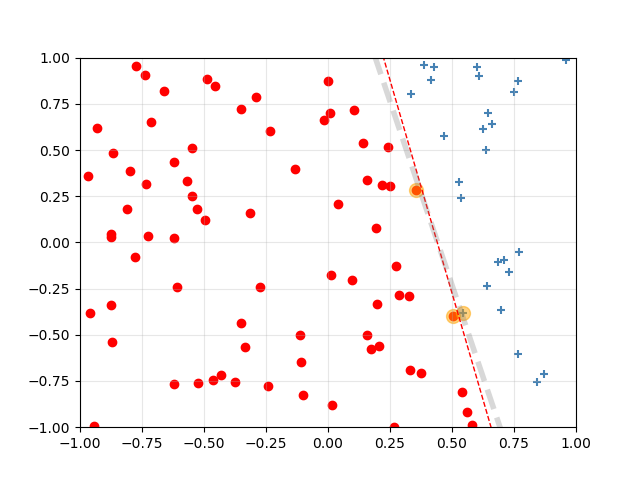

In [17]:
# define final hypothesis g and its decision boundary
g = lambda X: np.sign( X @ w + b).reshape(-1,1)
g.db = lambda x: (- w[0] * x - b)/ (w[1] + 10e-7)

# plot the data with decision boundary of g, actual decision boundary of f and the support vectors
plot_data(X, g(X), g.db)
x = np.arange(-1., 1., 0.01)
plt.plot(x, f.db(x), c='gray', ls='dashed', lw=4., alpha=.3)
plt.scatter(X[idx][:,0], X[idx][:,1], color='orange', alpha=.5, s=100);

#### Implementation for Experiment

The above approach demonstrates how a hard-margin SVMs can be implemented. Now we will implement the SVM classifier for subsequent experimentation using `scikit-learn`'s fast `libsvm` based implementation:

In [18]:
# maximum float value on this machine
F_MAX = np.finfo(dtype=float).max


class SVMClassifier:
    '''Hard margin SVM based binary classifier.'''
    
    def __init__(self, X, Y):       
        self._h = svm.SVC(C = F_MAX, kernel='linear').fit(X, Y.ravel())
        self.E_in = self.E(X, Y)
        self.sv_count = np.sum(self._h.n_support_)
    
    def __call__(self, X):
        Y_hat = self._h.predict(X).reshape(-1,1)
        return Y_hat

    def E(self, X, Y):
        N, d = X.shape
        E = np.sum(Y != self(X)) / float(N)
        return E

Now we can prepare the experiments as:

In [19]:
def experiment_pla_vs_svm(N=100, N_test=1000, repeat=1000, f=None, gen=generate_data):
    data = []
    sv_count = []
    i = 0
    
    while i < repeat:
        # generate test data and function
        X, Y, f = gen(N, f)
        if np.all(np.sign(Y) == -1) or np.all(np.sign(Y) == 1): continue

        # training
        g_pla = PerceptronClassifier(X, Y)
        g_svm = SVMClassifier(X, Y)

        # obtain the out of sample error rate using the generated function f
        X_test, Y_test, _ = gen(N_test, f)
        E_out = g_pla.E(X_test, Y_test), g_svm.E(X_test, Y_test)

        # store data
        data.append(E_out)
        sv_count.append(g_svm.sv_count)
        
        if i%100 == 0:
            print('experiment (run={}):\tE_out_pla={:.3f} / E_out_svm={:.3f}'.format(i, *E_out))

        i += 1
    
    # process and print results
    results, sv_count = np.array(data), np.array(sv_count)
    sep = '-'*14
    print('\nAverage Errors\n{}\nE_out_pla\t= {:.3f}\nE_out_svm\t= {:.3f}\n\nRatio (<)\n{}\nE_out_pla\t= {:.2f}%\nE_out_svm\t= {:.2f}%'.format(
        sep, 
        *np.mean(results, axis=0),
        sep, 
        (results[results[:,0] < results[:,1]].shape[0] / repeat) * 100,
        (results[results[:,1] < results[:,0]].shape[0] / repeat) * 100
    ))
    return results, sv_count

### P8

For $N = 10$ repeat the experiment for $1000$ runs. How often is $g_{SVM}$ better than $g_{PLA}$ in approximating $f$ (i.e., has a lower $E_{out}$)?

In [23]:
res, _ = experiment_pla_vs_svm(N=10)

experiment (run=0):	E_out_pla=0.296 / E_out_svm=0.125
experiment (run=100):	E_out_pla=0.193 / E_out_svm=0.121
experiment (run=200):	E_out_pla=0.275 / E_out_svm=0.161
experiment (run=300):	E_out_pla=0.029 / E_out_svm=0.009
experiment (run=400):	E_out_pla=0.092 / E_out_svm=0.049
experiment (run=500):	E_out_pla=0.154 / E_out_svm=0.014
experiment (run=600):	E_out_pla=0.191 / E_out_svm=0.130
experiment (run=700):	E_out_pla=0.146 / E_out_svm=0.035
experiment (run=800):	E_out_pla=0.063 / E_out_svm=0.122
experiment (run=900):	E_out_pla=0.041 / E_out_svm=0.034

Average Errors
--------------
E_out_pla	= 0.096
E_out_svm	= 0.082

Ratio (<)
--------------
E_out_pla	= 40.90%
E_out_svm	= 58.20%


### P9

For $N = 100$ repeat the experiment for $1000$ runs. How often is $g_{SVM}$ better than $g_{PLA}$ in approximating $f$ (i.e., has a lower $E_{out}$)?

In [24]:
res, sv_count = experiment_pla_vs_svm(N=100)

experiment (run=0):	E_out_pla=0.018 / E_out_svm=0.012
experiment (run=100):	E_out_pla=0.004 / E_out_svm=0.021
experiment (run=200):	E_out_pla=0.002 / E_out_svm=0.006
experiment (run=300):	E_out_pla=0.005 / E_out_svm=0.011
experiment (run=400):	E_out_pla=0.011 / E_out_svm=0.004
experiment (run=500):	E_out_pla=0.002 / E_out_svm=0.000
experiment (run=600):	E_out_pla=0.020 / E_out_svm=0.009
experiment (run=700):	E_out_pla=0.017 / E_out_svm=0.022
experiment (run=800):	E_out_pla=0.021 / E_out_svm=0.015
experiment (run=900):	E_out_pla=0.005 / E_out_svm=0.003

Average Errors
--------------
E_out_pla	= 0.013
E_out_svm	= 0.011

Ratio (<)
--------------
E_out_pla	= 35.60%
E_out_svm	= 58.70%


### P10

For the case $N = 100$, which of the following is the closest to the average number of support vectors of $g_{SVM}$ (averaged over the 1000 runs)?

In [25]:
print('Average No SV\n-------------\nc_sv\t= {}'.format(int(np.round(sv_count.mean()))))

Average No SV
-------------
c_sv	= 3
